# Figure 11 --- Two-player experiment

In [1]:
import sys
sys.path.append("../src")

import warnings
warnings.filterwarnings("ignore")

import PIL
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path
from scipy.stats import pearsonr
from statsmodels.stats.proportion import proportions_ztest

from Config.config import PATHS
from Utils.indices import AlternationIndex
from Utils.utils import GetMeasurements, Grid
from Utils.plot_utils import PlotsAndMeasures, BarRenderer

In [2]:
file_name = '2-player-UR.csv'
file = PATHS['human_data'] / Path(file_name)
print(f'Loading data from {file}...')
data = pd.read_csv(file)
data['model'] = data['treatment']
data.head(2)

Loading data from /Users/edgar/Documents/GitHub/Cognitive_Models_El_Farol_Bar_Problem/data/human/2-player-UR.csv...


,source,treatment,group,round,player,choice,score,attendance,ac_score,threshold,num_players,room,decision,model
0,human,score + grid,Grupo-0001,1,405186428721292,0,0,1,25,0.5,2,Grupo-0001,0,score + grid
1,human,score + grid,Grupo-0001,1,728608683559397,1,1,1,25,0.5,2,Grupo-0001,1,score + grid


### Playout examples

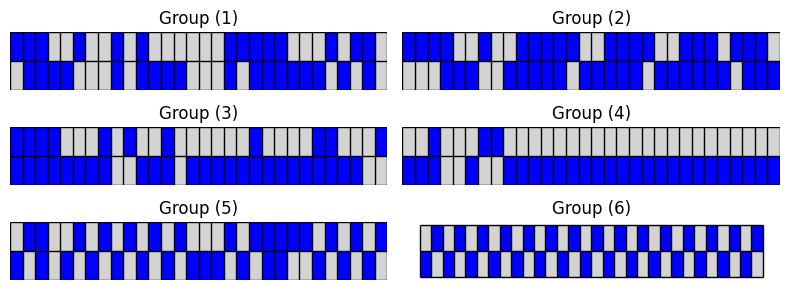

In [3]:
#-------------------------------
# Select groups
#-------------------------------
groups = [
    'Grupo-0017', 'Grupo-0022', 'Grupo-0004',
    'Grupo-0021', 'Grupo-0008', 'Grupo-0006'
]
#-------------------------------
# Plot groups
#-------------------------------
grid = Grid(len(groups))
fig, axes = plt.subplots(
    grid.rows, grid.cols, 
    figsize=(grid.cols*4, grid.rows),
    tight_layout=True
)
for i, group in enumerate(groups):
    df = data[data['room'] == group]
    bar_renderer = BarRenderer(data=df)
    bar_renderer.render(
        ax=axes[grid.index_to_pair(i)], 
        title=f"Group ({i+1})",
        num_rounds=30
    )

# Convert figure to image array
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
second_row_array = np.array(pil_image)

### Average score per round

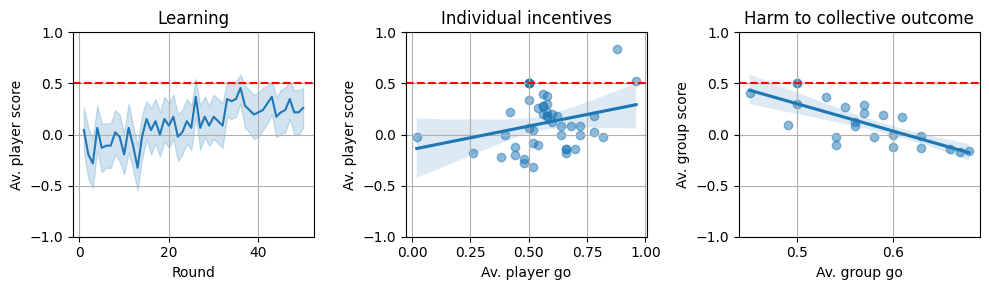

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(10,3), tight_layout=True)

# Learning: average score increases per round
sns.lineplot(
    x='round', y='score', data=data,
    ci=95, ax=ax[0]
)
ax[0].set_xlabel('Round')
ax[0].set_ylabel("Av. player score")
ax[0].set_title("Learning")
ax[0].grid()
ax[0].axhline(0.5, ls='--', color='red')
ax[0].set_ylim([-1,1])

# Individual incentives: the more the player goes, the higher the average score
player_av_scores = data.groupby(['player']).agg({
    'score':'mean',
    'decision':'mean'
})
sns.regplot(
    x='decision', y='score',
    scatter_kws={'alpha': 0.5}, 
    data=player_av_scores, ax=ax[1]
)
ax[1].set_xlabel("Av. player go")
ax[1].set_ylabel("Av. player score")
ax[1].set_title("Individual incentives")
ax[1].grid()
ax[1].axhline(0.5, ls='--', color='red')
ax[1].set_ylim([-1,1])

# Harm to collective outcome
group_av_scores = data.groupby(['group']).agg({
    'score':'mean',
    'decision':'mean'
})
sns.regplot(
    x='decision', y='score', 
    scatter_kws={'alpha': 0.5}, 
    data=group_av_scores, ax=ax[2]
)
ax[2].set_xlabel("Av. group go")
ax[2].set_ylabel("Av. group score")
ax[2].set_title("Harm to collective outcome")
ax[2].grid()
ax[2].axhline(0.5, ls='--', color='red')
ax[2].set_ylim([-1,1])

# Convert figure to image array
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
first_row_array = np.array(pil_image)

In [5]:
# fig.savefig(PATHS['bar_images'] / 'learning.png', dpi=300, bbox_inches='tight')

Pearson coefficients per player

In [6]:
r, p_value = pearsonr(player_av_scores['decision'], player_av_scores['score'])

print(f"Pearson correlation coefficient: {r:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"{r:.3f} (p={p_value:.3f})")


Pearson correlation coefficient: 0.2775
P-value: 6.1872e-02
0.278 (p=0.062)


Pearson coefficients per group

In [7]:
r, p_value = pearsonr(group_av_scores['decision'], group_av_scores['score'])

print(f"Pearson correlation coefficient: {r:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"{r:.3f} (p={p_value:.3f})")

Pearson correlation coefficient: -0.7536
P-value: 3.3044e-05
-0.754 (p=0.000)


### Distribution of relevant measures

In [8]:
# Calculate alternation index per group
gm = GetMeasurements(
    data=data,
    measures=['efficiency', 'bounded_efficiency', 'inequality']
)
df = gm.get_measurements()
alt_index = AlternationIndex.from_file(priority='sklearn')
df['alternation index'] = alt_index(df)

av_scores = data.groupby(['treatment', 'group']).agg({
    'score':'mean',
    'decision':'mean'
}).reset_index()

In [9]:
# Alternation percentages

alt_perc = alt_index.alt_precentage(df, columns=['treatment'])
alt_perc

,alternation,count,alternation_percentage
treatment,,,
only score,2,13,0.153846
score + grid,3,10,0.300000


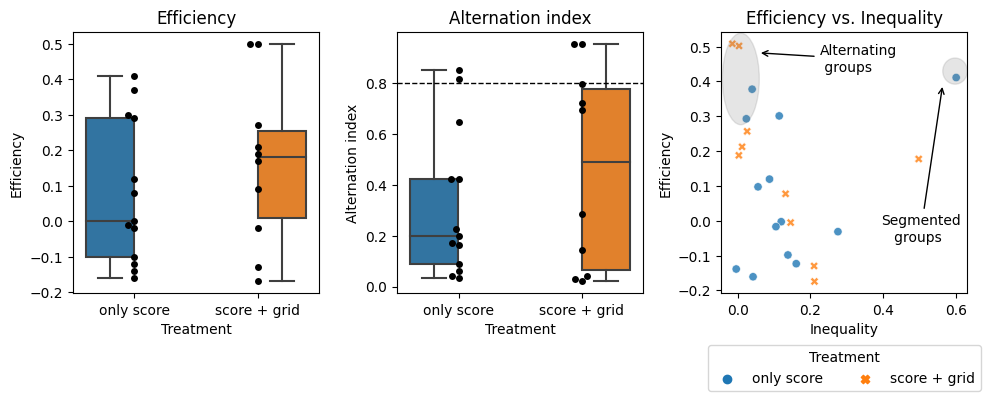

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(10,4), tight_layout=True)

# Distribution of efficiency
sns.boxplot(
    x='treatment', y='score', hue='treatment',
    data=av_scores, ax=ax[0], 
    order=['only score', 'score + grid'],
    hue_order=['only score', 'score + grid'],
)
sns.swarmplot(
    x='treatment', y='score', color='black',
    data=av_scores, ax=ax[0], order=['only score', 'score + grid'],
    hue_order=['only score', 'score + grid'],
)
ax[0].set_xlabel('Treatment')
ax[0].set_ylabel('Efficiency')
ax[0].set_title('Efficiency')
ax[0].legend().remove()

# Distribution of alternation index per treatment
sns.boxplot(
    x='treatment', y='alternation index', hue='treatment',
    data=df, ax=ax[1], order=['only score', 'score + grid'],
    hue_order=['only score', 'score + grid'],
)
sns.swarmplot(
    x='treatment', y='alternation index',
    data=df, color='black', ax=ax[1],
    order=['only score', 'score + grid'],
    hue_order=['only score', 'score + grid'],
)
ax[1].set_xlabel('Treatment')
ax[1].set_ylabel('Alternation index')
ax[1].set_title('Alternation index')
ax[1].axhline(y=0.8, color='black', linestyle='--', linewidth=1)
ax[1].legend().remove()

# Scatter plot efficiency vs. inequality
df_jitter = df.copy()
n = df_jitter.shape[0]
df_jitter['inequality'] = df_jitter['inequality'] + np.random.normal(0,0.0075, n)
df_jitter['efficiency'] = df_jitter['efficiency'] + np.random.normal(0,0.0075, n)
sns.scatterplot(
    x='inequality', y='efficiency',
    data=df_jitter, hue='treatment', style='treatment',
    alpha=0.8, ax=ax[2],
    hue_order=['only score', 'score + grid'],
)

# Show the alternating groups on the top-left corner
circle = patches.Ellipse(
    (0.08, 0.82), width=0.15, height=0.35,
    transform=ax[2].transAxes, 
    color='gray', alpha=0.2, 
)
ax[2].add_patch(circle)
# Add an arrow pointing to the cluster
ax[2].annotate(
    'Alternating\n groups',
    xy=(0.15, 0.92), xycoords='axes fraction',
    xytext=(0.4, 0.85), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10
)

# Show the segmented groups on the top-right corner
circle = patches.Circle((0.95, 0.85), 0.05, transform=ax[2].transAxes, 
                        color='gray', alpha=0.2)
ax[2].add_patch(circle)
# Add an arrow pointing to the cluster
ax[2].annotate(
    'Segmented\n   groups',
    xy=(0.9, 0.8), xycoords='axes fraction',
    xytext=(0.65, 0.2), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10
)
ax[2].set_xlabel('Inequality')
ax[2].set_ylabel('Efficiency')
ax[2].set_title('Efficiency vs. Inequality')
ax[2].legend(
    title='Treatment',
    loc='lower center', 
    bbox_to_anchor=(0.5, -.4),
    ncol=2
)

# Convert figure to image array
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
third_row_array = np.array(pil_image)

# Statistic tests

Difference of average efficiency between treatments using a Mann-Whitney U test.

In [11]:
scores_treatment1 = av_scores[av_scores['treatment'] == 'only score']['score']
scores_treatment2 = av_scores[av_scores['treatment'] == 'score + grid']['score']

u_stat, p_value = stats.mannwhitneyu(scores_treatment1, scores_treatment2, alternative='two-sided')

print(f"Mann-Whitney U statistic: {u_stat}")
print(f"P-value: {p_value}")
print(rf"x1 = {scores_treatment1.mean():.3f}")
print(rf"x2 = {scores_treatment2.mean():.3f}")
print(f"{u_stat:.3f} (p={p_value:.3f})")

Mann-Whitney U statistic: 53.5
P-value: 0.4949049282714102
x1 = 0.078
x2 = 0.161
53.500 (p=0.495)


Differnece in Alternation Index

In [12]:
scores_treatment1 = df[df['treatment'] == 'only score']['alternation index']
scores_treatment2 = df[df['treatment'] == 'score + grid']['alternation index']

u_stat, p_value = stats.mannwhitneyu(scores_treatment1, scores_treatment2, alternative='two-sided')

print(f"Mann-Whitney U statistic: {u_stat}")
print(f"P-value: {p_value}")
print(rf"x1 = {scores_treatment1.mean():.3f}")
print(rf"x2 = {scores_treatment2.mean():.3f}")
print(f"{u_stat:.3f} (p={p_value:.3f})")

Mann-Whitney U statistic: 58.0
P-value: 0.6867918992281867
x1 = 0.318
x2 = 0.463
58.000 (p=0.687)


Difference in proportion of Alternation Percentage

In [16]:
# Input data
# x = number of successes in each group
# n = number of trials in each group
x = alt_perc['alternation']
n = alt_perc['count'] 

# Two-proportion z-test
stat, p_value = proportions_ztest(count=x, nobs=n, alternative='two-sided')

print(f"Z-statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"x1 = {x[0]:.3f}")
print(f"x2 = {x[1]:.3f}")
print(f"n1 = {n[0]:.3f}")
print(f"n2 = {n[1]:.3f}")
print(f"{stat:.3f} (p={p_value:.3f})")

Z-statistic: -0.8424
P-value: 0.3996
x1 = 2.000
x2 = 3.000
n1 = 13.000
n2 = 10.000
-0.842 (p=0.400)


# All panels for Figure 11

(-0.5, 999.5, 399.5, -0.5)

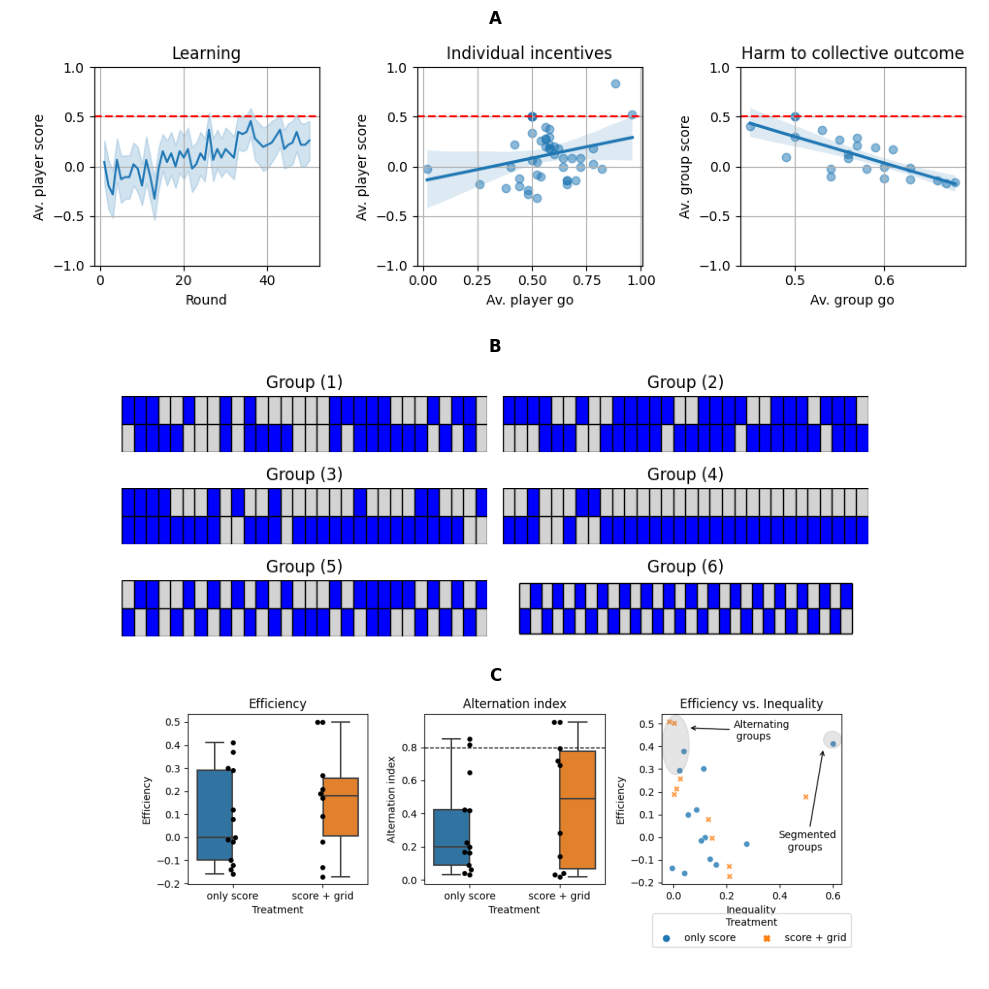

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(10,10), tight_layout=True)

ax[0].imshow(first_row_array)
ax[1].imshow(second_row_array)
ax[2].imshow(third_row_array)

ax[0].set_title('A', fontweight="bold")
ax[1].set_title('B', fontweight="bold")
ax[2].set_title('C', fontweight="bold")

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

In [17]:
fig.savefig('Figure11.png', dpi=300, bbox_inches='tight')

---

fig, ax = plt.subplots(1, 1, figsize=(4,4), tight_layout=True)

# Scatter plot efficiency vs. inequality
df_jitter = df.copy()
n = df_jitter.shape[0]
df_jitter['inequality'] = df_jitter['inequality'] + np.random.normal(0,0.0075, n)
df_jitter['efficiency'] = df_jitter['efficiency'] + np.random.normal(0,0.0075, n)
sns.scatterplot(
    x='inequality', y='efficiency',
    data=df_jitter, hue='treatment', style='treatment',
    alpha=0.8, ax=ax,
    hue_order=['only score', 'score + grid'],
)

# Show the alternating groups on the top-left corner
circle = patches.Circle(
    (0.08, 0.92), 0.075, 
    transform=ax.transAxes, 
    color='gray', alpha=0.2, 
)
ax.add_patch(circle)
# Add an arrow pointing to the cluster
ax.annotate(
    'Alternating\n groups',
    xy=(0.15, 0.92), xycoords='axes fraction',
    xytext=(0.4, 0.9), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=8
)

# Show the alternating groups on the top-left corner
circle = patches.Circle((0.9, 0.875), 0.1, transform=ax.transAxes, 
                        color='gray', alpha=0.2)
ax.add_patch(circle)
# Add an arrow pointing to the cluster
ax.annotate(
    'Segmented\n   groups',
    xy=(0.9, 0.775), xycoords='axes fraction',
    xytext=(0.7, 0.2), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=8
)
ax.set_xlabel('Inequality')
ax.set_ylabel('Efficiency')
ax.set_title('Efficiency vs. Inequality')
ax.legend(
    title='Treatment',
    loc='lower center', 
    bbox_to_anchor=(0.5, -.4),
    ncol=2
)


fig.savefig(PATHS['bar_images'] / 'eff_vs_ineq.png', dpi=300)